In [32]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

In [34]:
# Set random seed for reproducibility
np.random.seed(42)
try:
    df = pd.read_csv('../Data/BrentOilPrices.csv')  # Ensure CSV has 'Date' and 'Price' columns
    df['Date'] = pd.to_datetime(df['Date'], format='mixed')
    df = df.sort_values('Date')
except FileNotFoundError:
    print("Error: 'brent_oil_prices.csv' not found. Please provide the correct file path.")
    exit()

# Compute log returns for stationarity
df['Log_Returns'] = np.log(df['Price']).diff()

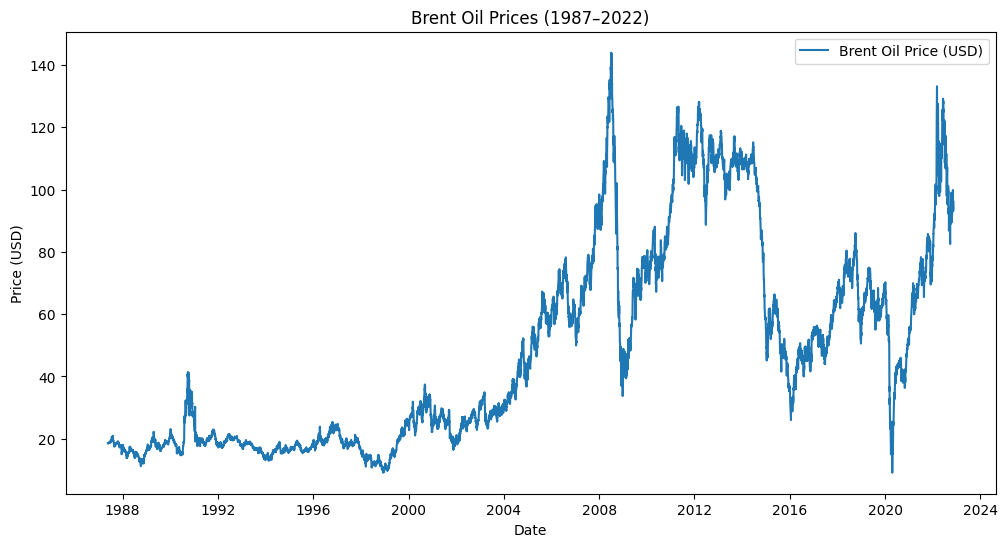

In [35]:
# 2. Exploratory Data Analysis (EDA)
# Plot raw price series
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Brent Oil Price (USD)')
plt.title('Brent Oil Prices (1987–2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

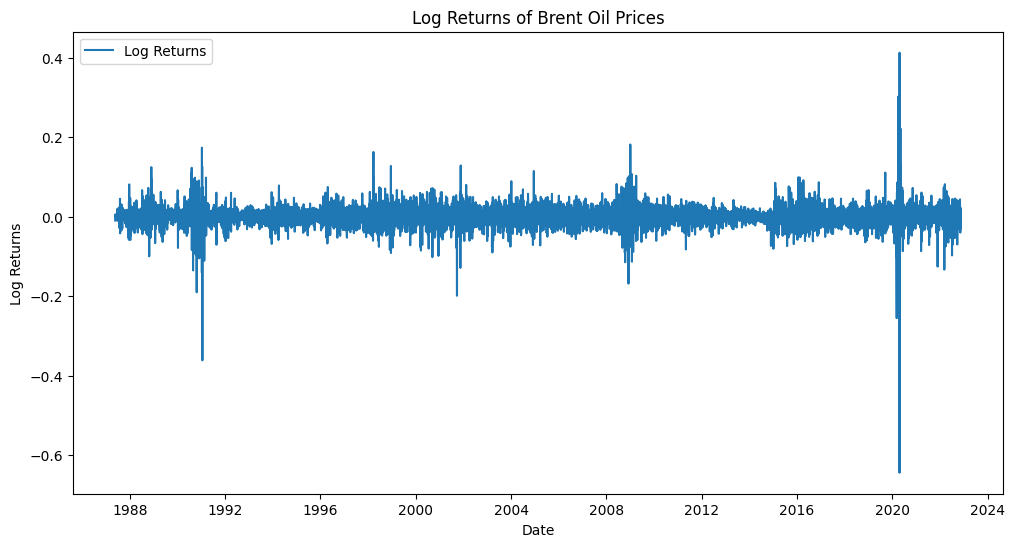

In [36]:
# Plot log returns to observe volatility
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Log_Returns'], label='Log Returns')
plt.title('Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

In [37]:
# Stationarity test (Augmented Dickey-Fuller)
adf_result = adfuller(df['Log_Returns'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')  # p < 0.05 suggests stationarity

ADF Statistic: -16.427113494485894
p-value: 2.4985801611428892e-29


In [38]:
# 3. Event Data Compilation
events = pd.DataFrame({
    'Event': [
        'Iraq Invasion', 'OPEC Production Decision', 'COVID-19 Pandemic',
        '2011 Libyan Civil War', '2008 Financial Crisis', '2018 US Sanctions on Iran',
        '1990 Gulf War', '2014 Ukraine Crisis', '2022 Russia-Ukraine Conflict',
        '2003 Iraq War', '2016 OPEC Production Cut'
    ],
    'Date': [
        '2002-03-20', '2014-11-27', '2020-03-11', '2011-02-15', '2008-09-15',
        '2018-05-08', '1990-08-02', '2014-03-01', '2022-02-24', '2003-03-20',
        '2016-11-30'
    ],
    'Description': [
        'US-led invasion disrupted oil supply',
        'OPEC maintained production, causing price crash',
        'Global demand collapsed due to lockdowns',
        'Civil war disrupted Libyan oil production',
        'Global financial crisis reduced oil demand',
        'Sanctions tightened oil supply from Iran',
        'Iraq’s invasion of Kuwait spiked prices',
        'Geopolitical tensions affected oil markets',
        'Conflict disrupted Russian oil supply',
        'War disrupted Iraqi oil production',
        'OPEC cut production to boost prices'
    ]
})
events['Date'] = pd.to_datetime(events['Date'])
events.to_csv('oil_market_events.csv', index=False)

In [41]:
# 4. Bayesian Change Point Model
prices = df['Price'].values
n_points = len(prices)
idx = np.arange(n_points)

with pm.Model() as model:
    # Prior for change point (tau)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_points-1)
    
    # Priors for mean prices before and after change point
    mu_1 = pm.Normal('mu_1', mu=np.mean(prices), sigma=10)
    mu_2 = pm.Normal('mu_2', mu=np.mean(prices), sigma=10)
    
    # Prior for standard deviation
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Switch function for mean
    mu = pm.math.switch(tau >= idx, mu_1, mu_2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=prices)
    
    # MCMC sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


/home/g/ALL/10/week10/Change-point-analysis-and-statistical-modelling/.venv/lib/python3.12/site-packages/rich/live.
py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    4520.016  3.191  4513.000  4525.000      0.107    0.082     867.0   
mu_1     21.436  0.277    20.929    21.973      0.004    0.004    5625.0   
mu_2     75.595  0.278    75.087    76.143      0.004    0.004    6128.0   
sigma    18.591  0.144    18.324    18.859      0.002    0.002    5486.0   

       ess_tail  r_hat  
tau       935.0   1.01  
mu_1     3077.0   1.00  
mu_2     2948.0   1.00  
sigma    2881.0   1.00  


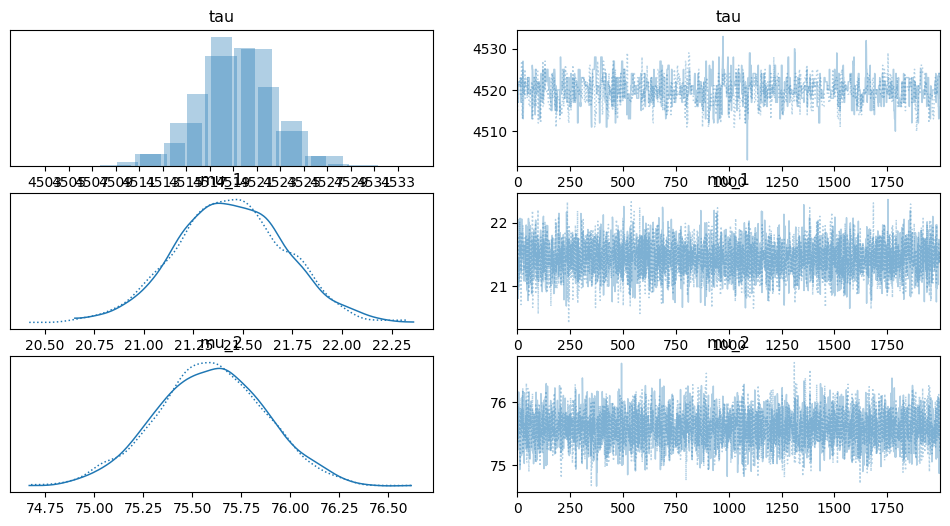

In [42]:
# 5. Model Diagnostics and Interpretation
# Check convergence
print(az.summary(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma']))
az.plot_trace(trace, var_names=['tau', 'mu_1', 'mu_2'])
plt.show()

# Posterior of change point
tau_posterior = trace.posterior['tau'].values.flatten()
change_point_idx = int(np.mean(tau_posterior))
change_point_date = df['Date'].iloc[change_point_idx]  # Fixed: Use df instead of data

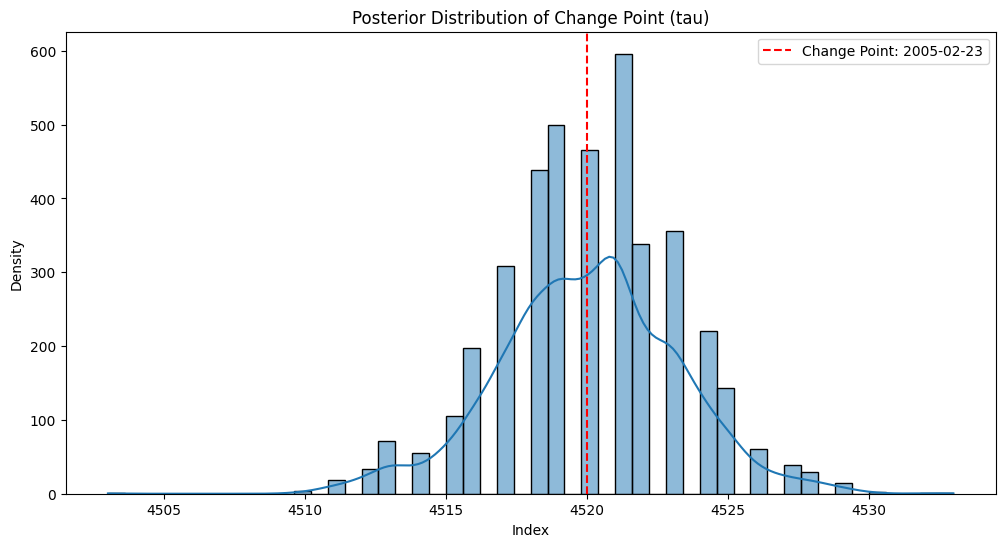

In [43]:
# Plot posterior distribution of tau
plt.figure(figsize=(12, 6))
sns.histplot(tau_posterior, bins=50, kde=True)
plt.axvline(change_point_idx, color='red', linestyle='--', label=f'Change Point: {change_point_date.date()}')
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Index')
plt.ylabel('Density')
plt.legend()
plt.show()

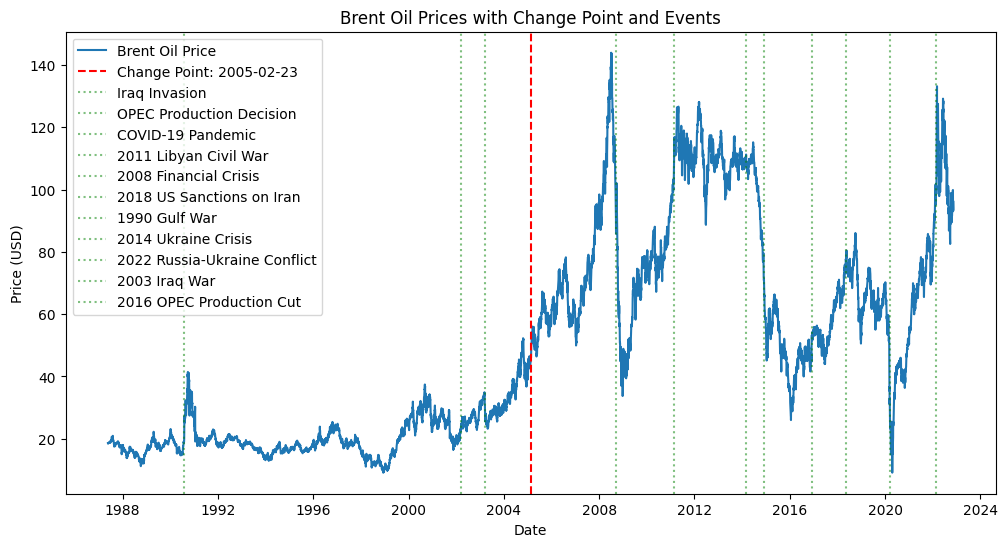

In [44]:
# Plot prices with change point and events
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], prices, label='Brent Oil Price')
plt.axvline(change_point_date, color='red', linestyle='--', label=f'Change Point: {change_point_date.date()}')
for _, event in events.iterrows():
    plt.axvline(event['Date'], color='green', linestyle=':', label=event['Event'], alpha=0.5)
plt.title('Brent Oil Prices with Change Point and Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [45]:
# 6. Quantify Impact
mu_1_posterior = trace.posterior['mu_1'].values.flatten()
mu_2_posterior = trace.posterior['mu_2'].values.flatten()
price_change = np.mean(mu_2_posterior) - np.mean(mu_1_posterior)
percent_change = (price_change / np.mean(mu_1_posterior)) * 100
print(f"Mean price before change point: ${np.mean(mu_1_posterior):.2f}")
print(f"Mean price after change point: ${np.mean(mu_2_posterior):.2f}")
print(f"Price change: ${price_change:.2f} ({percent_change:.2f}%)")

Mean price before change point: $21.44
Mean price after change point: $75.60
Price change: $54.16 (252.65%)


In [ ]:
# Associate change point with events
event_window = pd.Timedelta(days=30)
nearby_events = events[(events['Date'] >= change_point_date - event_window) & 
                      (events['Date'] <= change_point_date + event_window)]
print("\nNearby Events (within 30 days):")
for _, event in nearby_events.iterrows():
    print(f"- {event['Event']} on {event['Date'].date()}: {event['Description']}")

# 7. Interactive Dashboard
fig = px.line(df, x='Date', y='Price', title='Brent Oil Prices with Change Points and Events')
fig.add_vline(x=change_point_date.timestamp() * 1000, line_dash='dash', line_color='red',
              annotation_text=f'Change Point: {change_point_date.date()}')
for _, event in events.iterrows():
    fig.add_vline(x=event['Date'].timestamp() * 1000, line_dash='dot', line_color='green',
                  annotation_text=event['Event'])
fig.update_layout(xaxis_title='Date', yaxis_title='Price (USD)', showlegend=True)

# Try rendering in Jupyter; fallback to HTML if nbformat 
try:
    fig.show()
except ValueError as e:
    print(f"Error rendering Plotly figure: {e}")
    print("Saving plot as HTML file instead...")
    fig.write_html("brent_oil_prices_dashboard.html")
    print("Plot saved as 'brent_oil_prices_dashboard.html'. Open in a web browser to view.")


Nearby Events (within 30 days):
Error rendering Plotly figure: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Saving plot as HTML file instead...
Plot saved as 'brent_oil_prices_dashboard.html'. Open in a web browser to view.
